# Wissensbasierte Systeme 
## ML-Übung #1 "Nächste Nachbarn", "Random Forest" und "ANN"

**Dozenten:** Dr. Sina Keller und Felix Riese, M.Sc.

**Datum:** 04.04.2018

**Datensatz:** LUCAS-Datensatz, [Download der Daten]() mit [Beschreibung](https://esdac.jrc.ec.europa.eu/ESDB_Archive/eusoils_docs/other/EUR26102EN.pdf)

**Bearbeiter:** Louisa Raute

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 0. Einlesen der Daten 

In [2]:
# read data
df = pd.read_csv("20nm_lucas_train.csv", index_col=0, low_memory=False)

# drop NaN values
df.dropna(how="any", inplace=True)

In [3]:
# create list including all hyperspectral bands
hypbands = [str(x) for x in np.arange(400., 2500., 20)]

In [4]:
classes = {0: "Sand", 1: "LoamySand", 2: "SandyLoam", 3: "Loam", 4: "SiltLoam", 5: "Silt", 6: "SandyClayLoam",
           7: "ClayLoam", 8: "SiltyClayLoam", 9: "SandyClay", 10: "SiltyClay", 11: "Clay"}

## 1. Visualisieren der Daten

### a) Machen Sie sich mit dem Paket pandas und den Daten vertraut. Geben Sie Teile des Datensatzes aus mit .head(5) und .tail(5), .describe()und .info().

In [5]:
pd.DataFrame (data=df.head(5))

,clay,sand,silt,Label,sampleID,datetime,sampleID_hyp,400.0,420.0,440.0,...,2300.0,2320.0,2340.0,2360.0,2380.0,2400.0,2420.0,2440.0,2460.0,2480.0
0,7.0,48.0,45.0,3,100,2011-01-24 15:02:25,100,0.950155,0.999719,1.008172,...,0.520220,0.522260,0.527778,0.527192,0.528331,0.530558,0.536730,0.543470,0.548548,0.551938
1,13.0,60.0,27.0,2,1000,2010-09-30 12:50:01,1000,0.848359,0.903740,0.899109,...,0.360021,0.364199,0.369801,0.373795,0.381435,0.384547,0.393515,0.404616,0.413830,0.422948
2,40.0,8.0,52.0,10,10000,2010-10-19 10:06:16,10000,0.831824,0.905094,0.905048,...,0.334070,0.342818,0.352991,0.359492,0.368254,0.375521,0.388785,0.402323,0.413471,0.424280
3,26.0,56.0,18.0,6,10001,2010-10-19 13:00:01,10001,0.831294,0.884072,0.885816,...,0.454771,0.465106,0.483122,0.494005,0.506501,0.518085,0.536762,0.557487,0.574644,0.590322
4,22.0,37.0,41.0,3,10002,2011-04-30 10:26:27,10002,0.828527,0.892933,0.892133,...,0.331946,0.335807,0.342790,0.346072,0.352107,0.355876,0.366750,0.379759,0.390388,0.399697


In [6]:
pd.DataFrame (data=df.tail(5))

,clay,sand,silt,Label,sampleID,datetime,sampleID_hyp,400.0,420.0,440.0,...,2300.0,2320.0,2340.0,2360.0,2380.0,2400.0,2420.0,2440.0,2460.0,2480.0
12364,34.0,31.0,35.0,7,6034,2010-10-11 14:09:33,6034,0.745004,0.783842,0.761379,...,0.295530,0.307858,0.320188,0.320944,0.325316,0.331355,0.345482,0.356346,0.363162,0.371190
12365,46.0,8.0,46.0,10,6035,2010-10-14 07:05:39,6035,0.728629,0.776924,0.764479,...,0.302826,0.314587,0.326568,0.329949,0.339597,0.345763,0.360954,0.376942,0.389208,0.403091
12366,35.0,24.0,41.0,7,6036,2010-11-05 08:42:18,6036,0.666690,0.703866,0.692557,...,0.279015,0.290668,0.299090,0.295358,0.300099,0.305994,0.318997,0.333161,0.346409,0.360965
12367,30.0,31.0,39.0,7,6037,2010-10-11 14:14:06,6037,0.829733,0.898168,0.904721,...,0.339420,0.348600,0.359592,0.362992,0.369120,0.372857,0.385392,0.397501,0.404704,0.412873
12368,27.0,25.0,49.0,7,6040,2010-09-30 16:45:16,6040,0.769325,0.825243,0.825210,...,0.297103,0.307587,0.316980,0.317003,0.324047,0.333186,0.347810,0.362577,0.376407,0.390172


In [7]:
pd.DataFrame (data=df.describe())

,clay,sand,silt,Label,400.0,420.0,440.0,460.0,480.0,500.0,...,2300.0,2320.0,2340.0,2360.0,2380.0,2400.0,2420.0,2440.0,2460.0,2480.0
count,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,...,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000
mean,18.878567,43.517827,37.598351,3.996119,0.859295,0.907445,0.904843,0.898657,0.881365,0.846472,...,0.381308,0.386309,0.393146,0.394261,0.398277,0.402464,0.411768,0.421801,0.430155,0.437542
std,12.902014,26.009770,17.869742,2.858707,0.107185,0.112263,0.118697,0.122668,0.125513,0.128884,...,0.080408,0.079133,0.078949,0.079806,0.080412,0.080735,0.081165,0.081958,0.082857,0.083565
min,0.000000,1.000000,0.000000,0.000000,0.374881,0.388916,0.381244,0.371220,0.358506,0.342232,...,0.188972,0.198578,0.204269,0.196687,0.198502,0.203628,0.209564,0.213101,0.216613,0.218536
25%,8.000000,21.000000,25.000000,2.000000,0.787155,0.833444,0.826710,0.816477,0.795786,0.756533,...,0.325085,0.330837,0.337964,0.338882,0.342509,0.346489,0.355445,0.364836,0.372540,0.379175
50%,17.000000,43.000000,37.000000,3.000000,0.855830,0.906144,0.903234,0.896756,0.877506,0.840298,...,0.370461,0.375523,0.382613,0.383997,0.387725,0.391748,0.401336,0.411253,0.419294,0.426484
75%,26.000000,64.000000,50.000000,6.000000,0.932613,0.984377,0.986430,0.983167,0.968006,0.935330,...,0.426165,0.430629,0.437507,0.439263,0.443846,0.448418,0.458107,0.468631,0.477365,0.484995
max,79.000000,99.000000,86.000000,11.000000,1.277730,1.326788,1.342613,1.350825,1.349180,1.334729,...,0.831457,0.832109,0.834317,0.834847,0.835965,0.837733,0.841793,0.846733,0.851502,0.854948


In [8]:
pd.DataFrame (data=df.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12369 entries, 0 to 12368
Columns: 112 entries, clay to 2480.0
dtypes: float64(108), int64(1), object(3)
memory usage: 10.7+ MB


""


### 1b) Finden Sie die Größe des Datensatzes und die Anzahl der tatsächlich verwendeten Klassen heraus.


In [9]:
df.shape

(12369, 112)

In [10]:
print(df.columns)

print("Größe des Datensatzes:" , df.shape[0])

Index(['clay', 'sand', 'silt', 'Label', 'sampleID', 'datetime', 'sampleID_hyp',
       '400.0', '420.0', '440.0',
       ...
       '2300.0', '2320.0', '2340.0', '2360.0', '2380.0', '2400.0', '2420.0',
       '2440.0', '2460.0', '2480.0'],
      dtype='object', length=112)
Größe des Datensatzes: 12369


### 1c) Visualisieren Sie den Datensatz geeignet in mehreren Plots (Histogramm, Pairplot, Heatmap...).

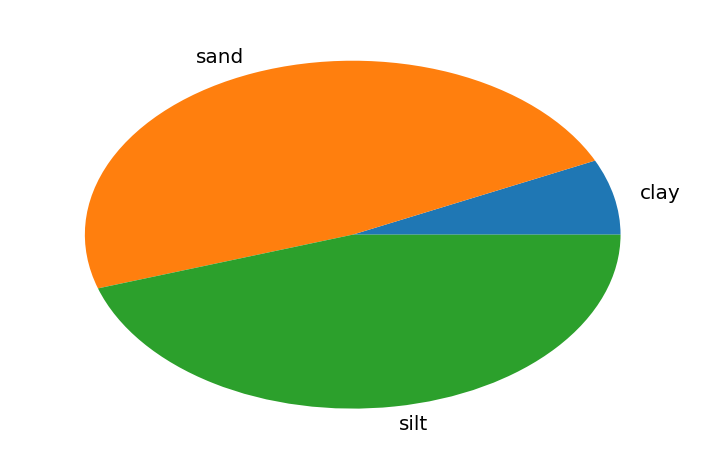

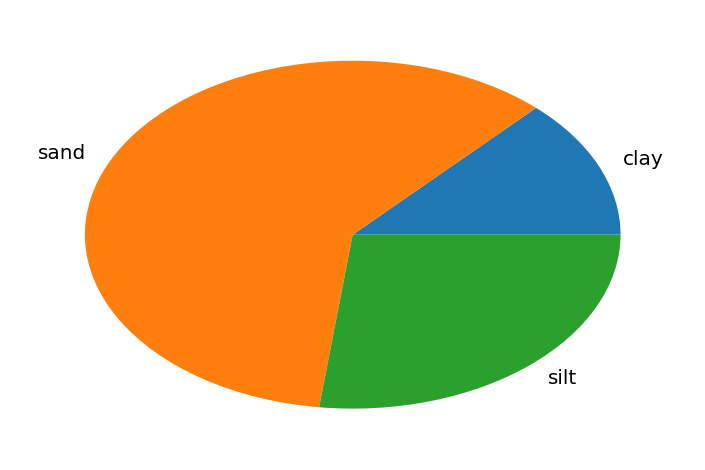

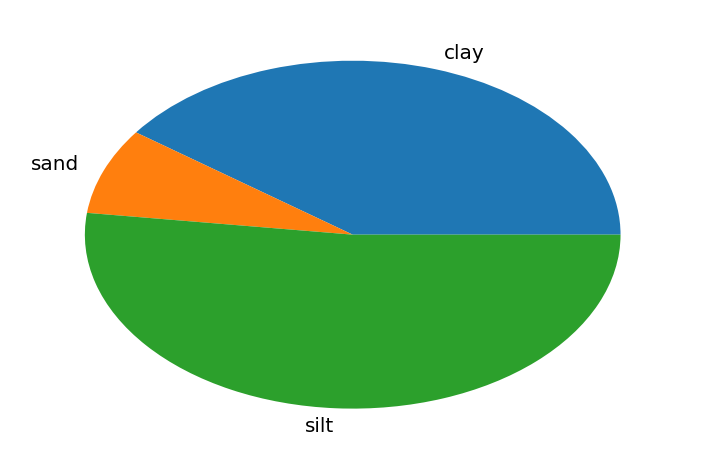

In [14]:


for x in range(0,3):
    
    fracs = [ df['clay'][x], df['sand'][x],df['silt'][x]]
    labels= 'clay', 'sand', 'silt'
    plt.pie(fracs, labels=labels)
    plt.show()

## 2. Vorprozessierung (BONUS)

### 2a) Implementieren Sie einen Filter zur Glättung der Spektren

### 2b) Implementieren Sie eine Dimensionsreduzierung mit 

(i) der Zusammenlegung von Bändern

(ii) Hauptachsentransformation (principal component analysis, PCA)

(iii) t-distributed stochastic neighbor embedding (t-dsne)

### 2c) Implementieren Sie eine Methode zur Skalierung (z.B. MinMax) der Daten

## 3. Klassifikation
Sie verwenden in dieser Aufgabe das Python-Paket _scikit-learn_.

### 3a) Splitten Sie den Datensatz in Trainings- und Testdaten im Verhältnis 1:9.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df,  test_size=0.1)
#x_train, x_test, y_train, y_test = train_test_split(df.drop(["label"], axis=1), df["label"], random_state=0, test_size=0.1)

### 3b) Implementieren Sie den Klassifikator Random Forest.  

### 3c) Implementieren Sie den Klassifikator k-Nächste-Nachbarn.

### 3d) Implementieren sie ein künstliches Neuronales Netz (ANN) als Klassifikator. 

### 3e) BONUS: Implementieren Sie ein künstliches Neuronales Netz (ANN) in Keras (statt scikit-learn). 

### 3f) Tranieren Sie beide Klassifikatoren auf den Trainingsdatensatz und prezidieren Sie auf den Testdatensatz. 

## 4. Evaluierung und Visualisierung der Ergebnisse

### 4a) Finden Sie geeignete Qualitätsmaße bzw. Fehlermaße einer Klassifikation. Implementieren Sie diese Maße. 

### 4b) Evaluieren Sie die Vorhersagen (Prediktionen) aus Aufgabe 3 anhand dieser Qualitätsmaße. Interpretieren Sie die Ergebnisse. 

### 4c) Visualisieren Sie die Klassifikationsergebnisse in geeigneter Form. 

### 4d) BONUS: Werten Sie den Einfluss der Vorprozessierungen aus Aufgabe 2 aus. 